In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from labbench import stopwatch

import matplotlib.pyplot as plt

# this is a development environment hack!
# after pip install of sea_ingest, you'd just import sea_ingest
import sea_ingest


data_path = Path("data")
plt.style.use("ieee-publication-double-column.mplstyle")

### Multiprocessing aggregation (dask.dataframe)
This is shown aggregating a single trace type (pfp) since it loads a single dataframe.

In [2]:
from sea_ingest.ziparchive import read_seamf_zipfile_as_ddf, restore_multiindex
import dask

with stopwatch():
    ddfs = sea_ingest.read_seamf_zipfile_as_ddf(
        data_path / "NIT-2022-12-13.zip",
        tz="America/New_York",
        localize=True,
        partition_size=300,
    )

    day_ddfs = {
        k: ddfs[k].loc["2022-11-01"] for k in ("psd", "pfp", "pvt", "channel_metadata")
    }

    day = dask.compute(day_ddfs, num_workers=8)[0]
    sea_ingest.restore_multiindex(day)

    for table_name in ("psd", "pfp", "pvt"):
        day[table_name] = day[table_name].astype("float32")

 INFO   2023-06-14 17:36:15.784 • labbench: 19.550 s elapsed


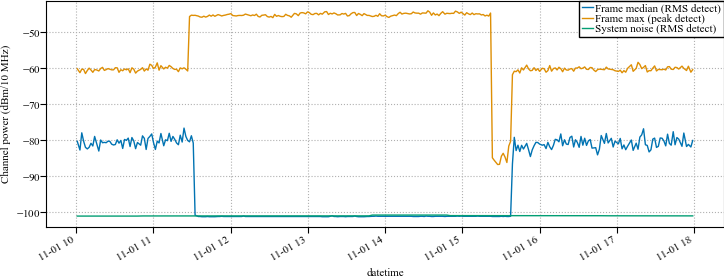

In [3]:
freq = 3605e6

pfp_indicators = {
    "Frame median (RMS detect)": sea_ingest.trace(
        day, "pfp", frequency=freq, capture_statistic="mean", detector="rms"
    ).quantile(0.5, axis=1),
    "Frame max (peak detect)": sea_ingest.trace(
        day, "pfp", frequency=freq, capture_statistic="max", detector="peak"
    ).max(axis=1),
    "System noise (RMS detect)": sea_ingest.trace(
        day, "channel_metadata", "cal_noise_figure_dB", frequency=freq
    )
    + -174
    + 70
    - 1,
}

pfp_indicators = pd.concat(pfp_indicators, axis=1)

(
    pfp_indicators.loc["2022-11-01 10:00:00":"2022-11-01 18:00:00"].plot(
        ylabel="Channel power (dBm/10 MHz)"
    )
);

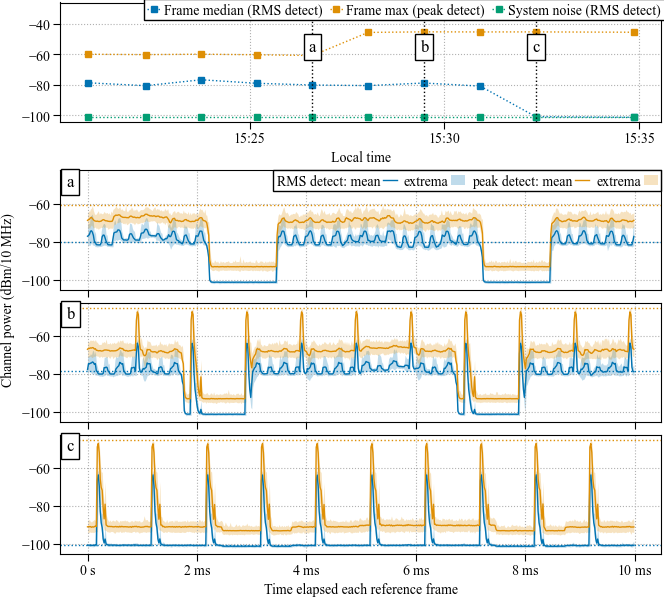

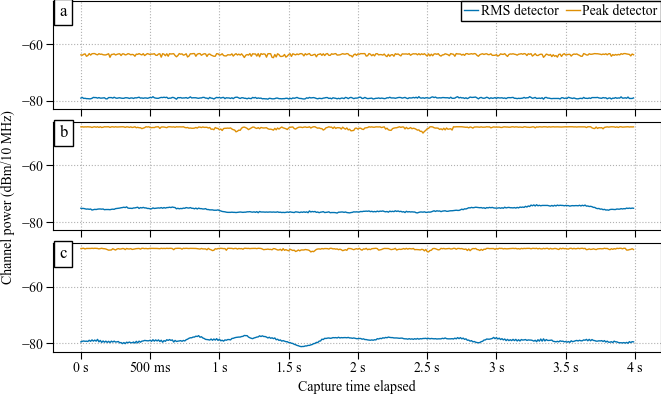

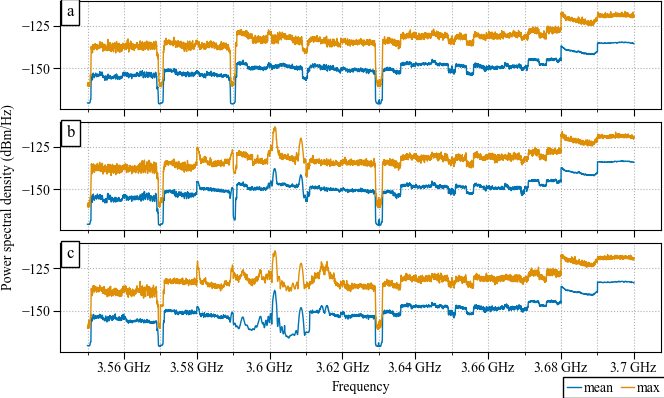

In [4]:
from sea_ingest.plots import (
    nearest_datetimes,
    plot_pfp_span_with_detail,
    plot_pvt_detail,
    plot_psd_detail,
)

plt.style.use("report.mplstyle")

detail_trace_targets = {
    "a": "2022-11-01 11:26",
    "b": "2022-11-01 11:30",
    "c": "2022-11-01 11:33",
}
mid_span = slice("2022-11-01 11:20:00", "2022-11-01 11:35:00")

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k, v in detail_trace_targets.items()
}

fig = plot_pfp_span_with_detail(day, freq, pfp_indicators, mid_span, detail_datetimes)
plt.savefig("nit_event_2022-11_pfp_start.svg")

fig = plot_pvt_detail(day, freq, detail_datetimes)
fig.savefig("nit_event_2022-11_pvt_start.svg")

fig = plot_psd_detail(day, detail_datetimes)
fig.savefig("nit_event_2022-11_psd_start.svg")

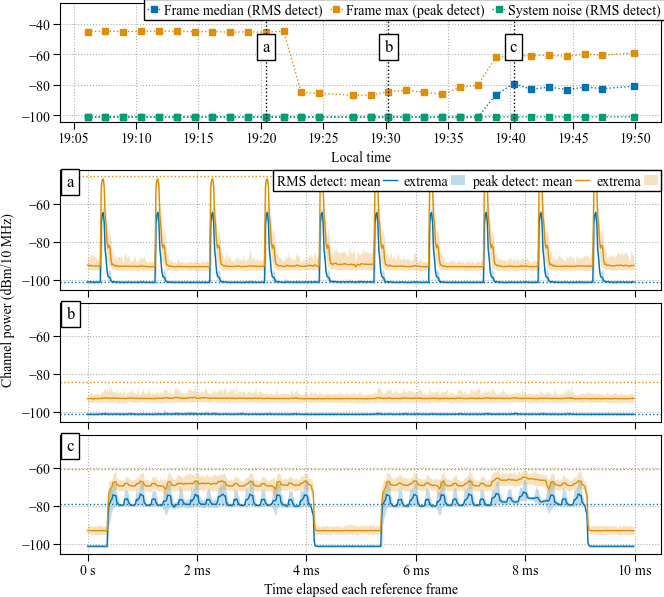

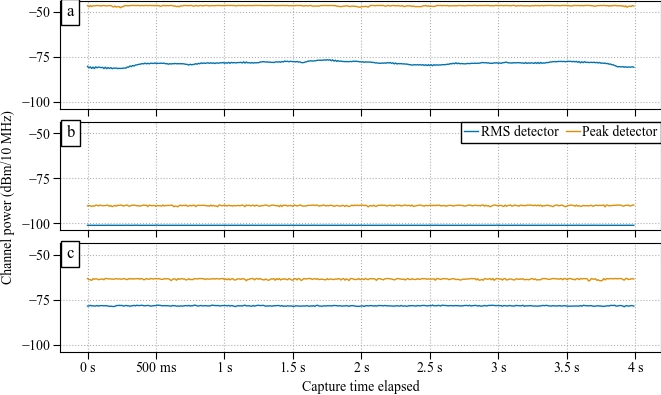

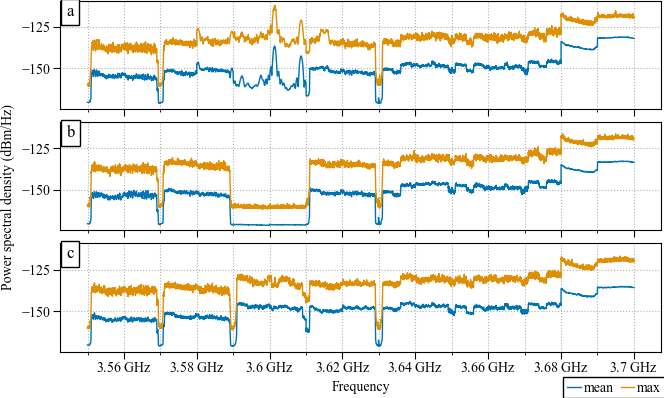

In [6]:
detail_trace_targets = {
    "a": "2022-11-01 15:20",
    "b": "2022-11-01 15:30",
    "c": "2022-11-01 15:40",
}
mid_span = slice("2022-11-01 15:05:00", "2022-11-01 15:50:00")

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k, v in detail_trace_targets.items()
}

fig = plot_pfp_span_with_detail(day, freq, pfp_indicators, mid_span, detail_datetimes)
plt.savefig("nit_event_2022-11_pfp_end.svg")

fig = plot_pvt_detail(day, freq, detail_datetimes, legend_ax_index=1)
plt.savefig("nit_event_2022-11_pvt_end.svg")

fig = plot_psd_detail(day, detail_datetimes)
fig.savefig("nit_event_2022-11_psd_end.svg")